## Notebook para EDA utilizando o dataset _auto-mpg_
> Este dataset é um dos conhecidos entre praticantes de DS/ML por ser simples simples para iniciantes, porém que nos permite entender as limitações de alguns algoritmos. O intuito deste notebook é entender um pouco da estrutura do dataset.
Disponível em: http://archive.ics.uci.edu/ml/datasets/Auto+MPG

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
from scipy import stats
plt.style.use('classic')

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('auto-mpg.csv',index_col='car name')

In [3]:
df.head()
#horsepower is not appearing and is numerical

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
car name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


In [4]:
df.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [5]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
dtype: object

_horsepower_ se apresenta como do tipo _objeto_ quando deveria se apresentar como _int_. Vamos procurar por padrões que nao sejam numéricos.

In [6]:
df[~df['horsepower'].str.contains('[\d]+')]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
car name,,,,,,,,
ford pinto,25.0,4,98.0,?,2046,19.0,71,1
ford maverick,21.0,6,200.0,?,2875,17.0,74,1
renault lecar deluxe,40.9,4,85.0,?,1835,17.3,80,2
ford mustang cobra,23.6,4,140.0,?,2905,14.3,80,1
renault 18i,34.5,4,100.0,?,2320,15.8,81,2
amc concord dl,23.0,4,151.0,?,3035,20.5,82,1


Alguns kernels existentes optam por remover estes valores, neste notebook a título de exploração vamos testar a utilização de regressão linear como método para imputar valores.

Uma abordagem mais sensível para o caso de haverem mais dados que se assemelhassem a estes seria utilizar KNN regressores considerando que haveria maior quantidade de pontos dispersos próximos destas 6 observações

## A ideia agora é testar o knn regressor e comparar com a regressão para imputar valores: ler o artigo do analythics vidhya

O KNN talvez seja bem mais complexo para imputação pois variáveis categóricas como país deveriam para melhor serem alimentadas ao modelo serem One Hot Code Labeling(pd.get_dummy). Mesmo com one hot encoding a regressão linear parece ter melhor pontuação na validação cruzada então optamos por imputação via lin_reg

In [3]:
df_ready = df[df['horsepower'] != '?']
df_ready['horsepower'] = df_ready['horsepower'].astype('float')

df_to_input = df[df['horsepower'] == '?']
df_to_input = df_to_input[df_to_input.columns.difference(['horsepower'])]
#df_to_input['origin'] = pd.get_dummies(df_to_input['origin'])

In [4]:
from sklearn.model_selection import train_test_split, KFold,  cross_val_score
from sklearn.preprocessing import MinMaxScaler,RobustScaler,PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.decomposition import PCA

In [12]:
def KNNR(pred):
    df_ready['origin'] = pd.get_dummies(df_ready['origin'])
    
    X = df_ready[df_ready.columns.difference(['horsepower'])]
                                       
    X_train,X_test,y_train,y_test = train_test_split(
        X,df_ready['horsepower'],test_size = 0.2)

    scaler = MinMaxScaler(feature_range=(0, 1))

    #scalling all the DataFrames
    X_train = pd.DataFrame(scaler.fit_transform(X_train))
    X_test = pd.DataFrame(scaler.fit_transform(X_test))
    pred = pd.DataFrame(scaler.transform(pred))

    outer_cv = KFold(n_splits=5, shuffle=True)

    knn= KNeighborsRegressor(n_neighbors=3,weights='distance')
    knn.fit(X_train,y_train)
    
    nested_score = cross_val_score(knn, X=X_test, y=y_test, cv=outer_cv)
    print('Mean:',nested_score.mean(),'+/-',nested_score.std())

    y_pred = knn.predict(pred)
    return y_pred

KNNR(df_to_input)

Mean: 0.8593662659169379 +/- 0.03084515071824841


array([ 58.1624612 , 115.97639892,  61.01401305, 100.01299323,
        68.99861634,  70.24217273])

In [5]:
def lin_reg(pred):
    X_train,X_test,y_train,y_test = train_test_split(
        df_ready[df_ready.columns.difference(['horsepower'])],df_ready['horsepower'],test_size = 0.2,shuffle=True)

    outer_cv = KFold(n_splits=3, shuffle=True)

    reg = LinearRegression().fit(X_train,y_train)
    y_pred = reg.predict(pred)
    nested_score = cross_val_score(reg, X=X_test, y=y_test, cv=outer_cv)

    #print(r2_score(y_test,y_pred))
    print('Mean:',nested_score.mean(),'+/-',nested_score.std())
    return y_pred

lin_reg(df_to_input)

Mean: 0.833037993297575 +/- 0.03875238207284713


array([60.50719688, 95.38664354, 56.37764924, 97.56137345, 74.96792497,
       74.7644422 ])

In [6]:
new_df = df_to_input.copy()
new_df['horsepower'] = pd.Series((lin_reg(df_to_input)),index = new_df.index)
new_df

Mean: 0.8996647957349669 +/- 0.029053724107193434


,acceleration,cylinders,displacement,model year,mpg,origin,weight,horsepower
car name,,,,,,,,
ford pinto,19.0,4,98.0,71,25.0,1,2046,59.295120
ford maverick,17.0,6,200.0,74,21.0,1,2875,95.139161
renault lecar deluxe,17.3,4,85.0,80,40.9,2,1835,55.390669
ford mustang cobra,14.3,4,140.0,80,23.6,1,2905,98.384007
renault 18i,15.8,4,100.0,81,34.5,2,2320,75.365923
amc concord dl,20.5,4,151.0,82,23.0,1,3035,74.574073


### Criando a comparação para ambos os dataframes

In [7]:
df_inputed = pd.concat([new_df,df_ready],sort=True)

#### proxima etapa EDA

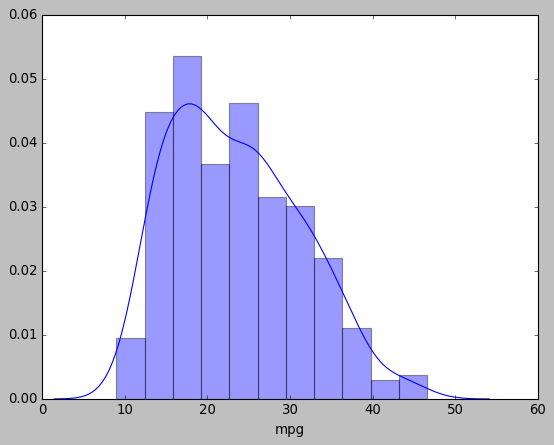

In [29]:
sns.distplot(df_inputed['mpg'],bins=11)

In [17]:
df_inputed.skew(axis=0)

acceleration    0.278777
cylinders       0.526922
displacement    0.719645
horsepower      1.102851
model year      0.011535
mpg             0.457066
origin          0.577521
weight          0.531063
dtype: float64

In [8]:
features = df_inputed.columns.difference(['mpg'])
correlations = df_inputed[features].corr().abs().unstack().sort_values().reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.tail(10)

,level_0,level_1,0
32,weight,horsepower,0.864941
33,horsepower,weight,0.864941
34,cylinders,weight,0.896017
35,weight,cylinders,0.896017
36,horsepower,displacement,0.897603
37,displacement,horsepower,0.897603
38,displacement,weight,0.932824
39,weight,displacement,0.932824
40,displacement,cylinders,0.950721
41,cylinders,displacement,0.950721


In [9]:
un_va = []
for feat in features:
    df_inputed[feat].value_counts()
    values = df_inputed[feat].value_counts()
    un_va.append([feat, values.max(), values.idxmax()])
un_va

[['acceleration', 23, 14.5],
 ['cylinders', 204, 4],
 ['displacement', 21, 97.0],
 ['horsepower', 22, 150.0],
 ['model year', 40, 73],
 ['origin', 249, 1],
 ['weight', 4, 1985]]

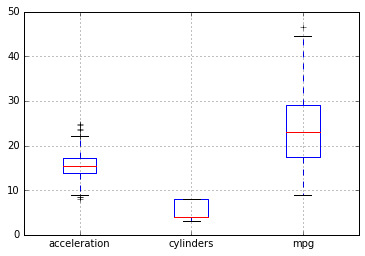

In [10]:
df_inputed[['acceleration','cylinders','mpg']].boxplot()

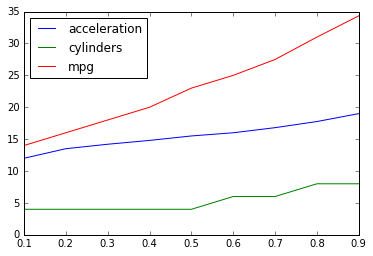

In [11]:
#checking 
df_inputed[['acceleration','cylinders','mpg']].quantile(np.arange(0.1,1.0,0.1)).plot.line()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021CD063C630>,
      dtype=object)

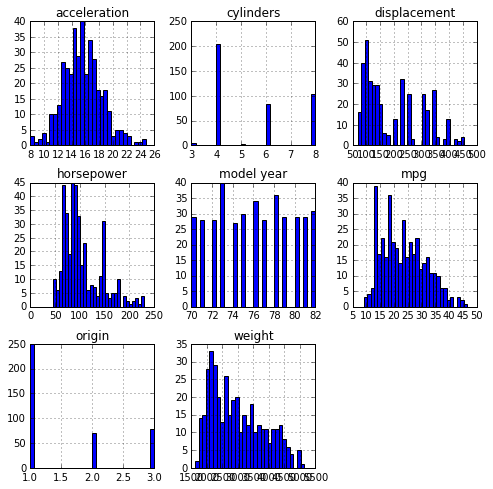

In [12]:
df_inputed.hist(bins=30,figsize=(8,8)) #checking distribution

In [13]:
#pd.crosstab(df_inputed['displacement']>100,df_inputed['mpg']>20) #check proportions of cars with various values of two variables

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021CD2649550>,
      dtype=object)

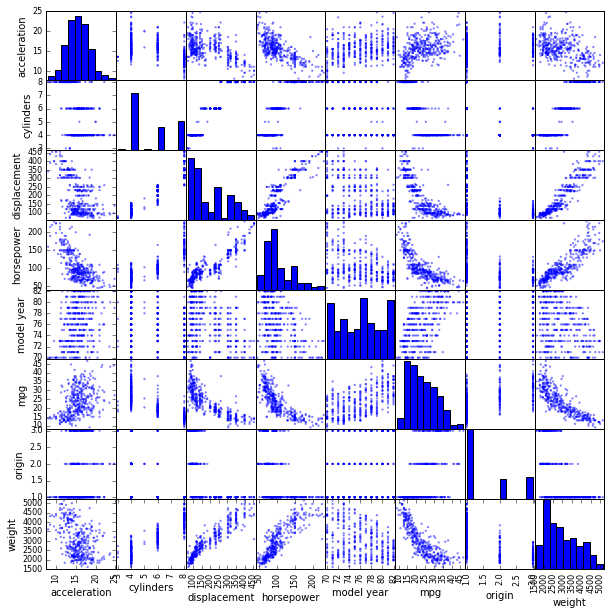

In [14]:
pd.scatter_matrix(df_inputed,figsize=(10,10))

In [15]:
def regressors(df,cols):
    '''Train 4 regression models outputing a visualizations and scores.
    
    Note: Models are Linear Regression,Ridge Regression, GBM and RF regressors.
    Note: In case of GBM/RF prints feature importances and for Ridge it prints
        its coefficients.
    Note: Using 5-fold CV it computes the scores of each model and plots a 
        boxplot with those scores.
        
    Parameters
    ----------
    df         (pandas DataFrame) Data Frame to be used for the regression.
    
    cols       (numpy array) Array with features to be used as predictors.
    
    Returns
    -------
    xxxx
    '''
    
    X_trn,X_tst,y_trn,y_tst = train_test_split(
        df[cols],df['mpg'],test_size=0.3)   
    
    models = []
    models.append(('LR', LinearRegression()))
    models.append(('RR', Ridge(alpha=10)))
    models.append(('GBM', GradientBoostingRegressor(n_estimators=2500,learning_rate=0.002)))
    models.append(('RF', RandomForestRegressor(n_estimators=2500)))

    # evaluate each model in turn
    results = []
    names = []
    scoring = 'r2'   
    seed = 13
    for name, model in models:
        #controling for randomness through random_state and K-fold
        kfold = KFold(n_splits=5, random_state=seed)
        #Dealing with outliers using RobustScaler
        pipe = make_pipeline(RobustScaler(),model)
        cv_results = cross_val_score(pipe, X_trn, y_trn, cv=kfold, scoring=scoring)
        model.fit(X_trn,y_trn)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        if (name == 'RR') | (name == 'LR'):
            print (list(zip(cols,model.coef_)),'\n')
        elif (name == 'GBM') |(name == 'RF'):
            print(list(zip(cols,model.feature_importances_)),'\n')
    # boxplot algorithm comparison
    fig = plt.figure(figsize=(5,5))
    fig.suptitle('Comparing Regressors')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()
    
    for _,clf in models:
        try:
            feat_ = pd.Series(clf.feature_importances_,cols).sort_values(ascending=False)
            fig = plt.figure(figsize=(4,4))
            ax = fig.add_subplot(111)            
            feat_.plot(kind='bar', title='Feature Importances - {}'.format(_))            
            plt.show()
            
        except AttributeError as e:
            print(e)

LR: 0.813639 (0.012123)
[('acceleration', 0.02235459070182887), ('cylinders', -0.33104385960052723), ('displacement', 0.007906176676979319), ('horsepower', -0.0042955713353129326), ('model year', 0.7807200354048254), ('weight', -0.006739853103024593)] 

RR: 0.803964 (0.006932)
[('acceleration', 0.02246993848050008), ('cylinders', -0.2912261847012438), ('displacement', 0.007286338654012428), ('horsepower', -0.004347735202168011), ('model year', 0.7782869960553436), ('weight', -0.006741338862442747)] 

GBM: 0.875677 (0.034512)
[('acceleration', 0.017622241397631397), ('cylinders', 0.16142372872947705), ('displacement', 0.28981113770001254), ('horsepower', 0.08028335614257527), ('model year', 0.14223694988907976), ('weight', 0.3086225861412239)] 

RF: 0.884460 (0.037485)
[('acceleration', 0.02484591299032451), ('cylinders', 0.15687692470410108), ('displacement', 0.41809258017676737), ('horsepower', 0.08863779379533071), ('model year', 0.11835687008620505), ('weight', 0.19318991824727128)]

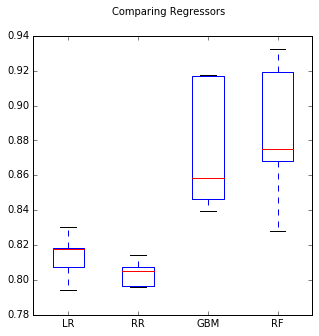

'LinearRegression' object has no attribute 'feature_importances_'
'Ridge' object has no attribute 'feature_importances_'


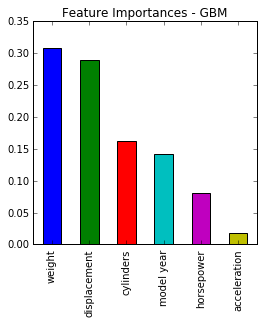

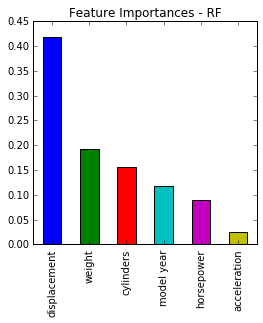

In [16]:
regressors(df_inputed,features.difference(['origin']))

LR: 0.797675 (0.008637)
[('acceleration', -0.005218603913354726), ('displacement', -0.0004278896471393254), ('model year', 0.7005351609350936), ('weight', -0.006808163399723404)] 

RR: 0.792603 (0.008879)
[('acceleration', -0.004901296168251778), ('displacement', -0.0004830790296982017), ('model year', 0.6982652155292406), ('weight', -0.0068042702514190725)] 

GBM: 0.859609 (0.019292)
[('acceleration', 0.021495984551405344), ('displacement', 0.3352018311145317), ('model year', 0.13700210663428775), ('weight', 0.5063000776997751)] 

RF: 0.870505 (0.032918)
[('acceleration', 0.03676038644874866), ('displacement', 0.4966981733382433), ('model year', 0.12066809272036134), ('weight', 0.34587334749264603)] 



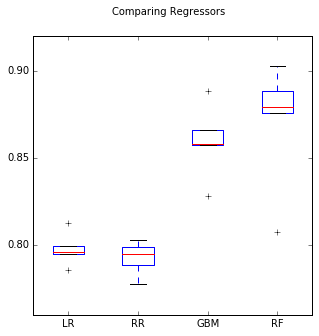

'LinearRegression' object has no attribute 'feature_importances_'
'Ridge' object has no attribute 'feature_importances_'


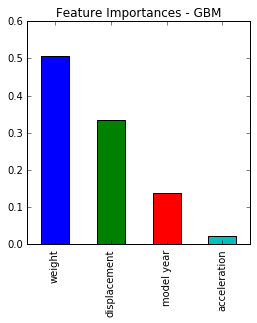

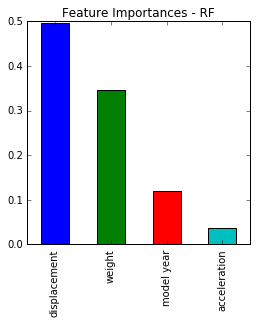

In [17]:
regressors(df_inputed,features.difference(['origin','horsepower','cylinders']))

In [197]:
df_inputed.corr()

,acceleration,cylinders,displacement,horsepower,model year,mpg,origin,weight
acceleration,1.000000,-0.505419,-0.543684,-0.689652,0.288137,0.420289,0.263047,-0.417457
cylinders,-0.505419,1.000000,0.950721,0.842550,-0.348746,-0.775396,-0.607511,0.896017
displacement,-0.543684,0.950721,1.000000,0.897133,-0.370164,-0.804203,-0.652001,0.932824
horsepower,-0.689652,0.842550,0.897133,1.000000,-0.413070,-0.776031,-0.486550,0.864525
model year,0.288137,-0.348746,-0.370164,-0.413070,1.000000,0.579267,0.152305,-0.306564
mpg,0.420289,-0.775396,-0.804203,-0.776031,0.579267,1.000000,0.569769,-0.831741
origin,0.263047,-0.607511,-0.652001,-0.486550,0.152305,0.569769,1.000000,-0.598482
weight,-0.417457,0.896017,0.932824,0.864525,-0.306564,-0.831741,-0.598482,1.000000


### Conclusions
*In the present case we may consider that models as Random Forest and GBM **may 'select' features automatically** so dropping them does not seem as a necessary step. While linear regression may not have their score lowered by leaving excess features in the model, ridge will be able to adjust coeficients due to a penalization term.*

*In order to deal partially with **randomness** we used a K-Fold CV to use same sets and fixed the random_state.[1]*

*As far as it was manually tested it seems that using **one feature would be enough** to obtain an R2 score above .70. For 'displacement', the stronger correlation to 'mpg' as well as **multicolinearity with 'horsepower', 'cylinders', 'weight' and even 'origin'** give us a hint from the very begin of our analysis that it could be the case of reducing considerably the amount of features used in our model.*

*Important to consider that **'origin' was not encoded properly**, through One-Hot Encoding as usually is the best practice. **Equivocate assumptions would be made by our model** such as origin 3 is somewhat higher than origin 2 or 1 when it is in fact a categorical feature.*

*Notwithstanding that 'displacement' is one of the most proeminent feature, more features help to improve prediction and mainly in our GBM/RF models.*

*In the current scenario, considering that enough features are available GBM/RF models outperform simpler models as Linear and Ridge Regressions.*

*Due to multicolinearity the **models are not stable concerning features used** to split the tree branches during fitting. This is observable in the varied outputs when we call our functions repeatedly.*

*Elucidating that for further analysis proper **hyperparameter tunning** would be considered either through **GridSearch with nested CV (or GridSearchCV itself)** (I am still studying CV) or most likely with **'hyperopt'(Bayesian)** library.[2]*

Next steps:
 - Present different scenarios of feature choice
 - Implement PCA(?)


## References

[1] https://machinelearningmastery.com/randomness-in-machine-learning/
[2] https://towardsdatascience.com/an-introductory-example-of-bayesian-optimization-in-python-with-hyperopt-aae40fff4ff0